In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from gensim.models import LdaModel, CoherenceModel
from gensim import corpora
import matplotlib.pyplot as plt
from scipy import stats as st
from mne import stats
from statannot import add_stat_annotation
from scipy import spatial
from lifelines import KaplanMeierFitter
from lifelines.utils import median_survival_times
from lifelines.statistics import proportional_hazard_test
from lifelines import CoxPHFitter

In [2]:
def create_heatmap(model, df, corpus):
    topics = model.get_document_topics(bow = corpus, minimum_probability = 0)
    
    new_df = pd.DataFrame(df['Sample'])
    new_df['Chr'] = df['Chr']
    new_df['Chr'] = pd.to_numeric(new_df['Chr'])
    
    columns = [[],[],[],[],[]]
    for topic in topics:
        for w in topic:
            columns[w[0]].append(w[1])
    
    new_df['1'] = columns[0]
    new_df['2'] = columns[1]
    new_df['3'] = columns[2]
    new_df['4'] = columns[3]
    new_df['5'] = columns[4]
    new_df = new_df.sort_values(by='Chr')
    return new_df

In [3]:
file = pd.read_table('/home/janneae/cns/steps/featurefiles/discretized_10_0.7_5.features', dtype=str)
ascat = pd.read_table('/home/janneae/cns/data/filteredAscatRaw.txt', dtype=str)
maf = pd.read_table('/home/janneae/cns/data/all_tcga_maf.txt', sep=' ')
cin = pd.read_table("../data/all_tcga_cin_measures.txt", sep=" ")
mutations = pd.read_table('../data/all_muts_pass_and_polyphen.txt', sep=' ')
gene_exp = pd.read_table('../data/all_tcga_gene_exp.txt', sep='\t')
sanchez_vega = pd.read_table('../data/sanchez_vega_pws_1026.csv', sep=';')
lda = LdaModel.load('../steps/gensim/lda/lda_t5_f10_b5.model')

/scratch/64672581/ipykernel_35560/893251082.py:5: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  mutations = pd.read_table('../data/all_muts_pass_and_polyphen.txt', sep=' ')


In [4]:
mutations = mutations[mutations.FILTER == 'PASS']

In [5]:
df = file.drop(['Sample', 'Chr', 'GCcSeg'], axis = 1)
listedDf = df.values.tolist()
dirichlet_dict = corpora.Dictionary(listedDf)
bow_corpus = [dirichlet_dict.doc2bow(text) for text in listedDf]
weights_df = create_heatmap(lda, file, bow_corpus)

In [6]:
nonsynonymous = mutations[mutations.Variant_Classification != 'Silent'].reset_index(drop=True).groupby('sampleID').count().reset_index()[['sampleID', 'Hugo_Symbol']]
nonsynonymous.rename(columns={'Hugo_Symbol':'num_mutations'}, inplace=True)

mutation_df = pd.merge(left = ascat[['ID', 'cancer_type']], right = nonsynonymous['num_mutations'], left_on='ID', right_on=nonsynonymous['sampleID']).drop_duplicates(subset='ID').reset_index(drop=True)
mutation_df.num_mutations = np.log10(mutation_df.num_mutations)
mutation_df.head()

,ID,cancer_type,num_mutations
0,TCGA-02-0003,GBM,1.690196
1,TCGA-02-0033,GBM,1.491362
2,TCGA-02-0047,GBM,1.857332
3,TCGA-02-0055,GBM,1.778151
4,TCGA-02-2470,GBM,1.778151


## Figure 1

In [24]:
boxplot_df = pd.merge(left = cin, right = ascat[['cancer_type']], left_on='sample_id', right_on=ascat['ID']).drop_duplicates(subset='sample_id').reset_index(drop=True)
boxplot_df['hrd_score'] = boxplot_df.lst + boxplot_df['Telomeric.AI'] + boxplot_df.hrd
boxplot_df = boxplot_df[['Telomeric.AI', 'lst', 'hrd', 'wGII', 'Ploidy', 'wFLOH', 'hrd_score', 'cancer_type']]

In [ ]:
fig = plt.figure(figsize=(12,15))
ax = sns.catplot(col="cancer_type", data=boxplot_df, kind="box", col_wrap=5, height=3)
plt.savefig('../figures/cinboxplots.pdf')

In [25]:
wgii_df = boxplot_df[['cancer_type', 'wGII']]
wgii_df.head()

,cancer_type,wGII
0,GBM,0.462361
1,GBM,0.162425
2,GBM,0.331508
3,GBM,0.245808
4,GBM,0.180239


In [26]:
sorted_wGII = wgii_df.groupby("cancer_type").mean().sort_values(by = 'wGII', ascending=True).index
sorted_mut = mutation_df.groupby("cancer_type").mean().sort_values(by = 'num_mutations', ascending=True).index

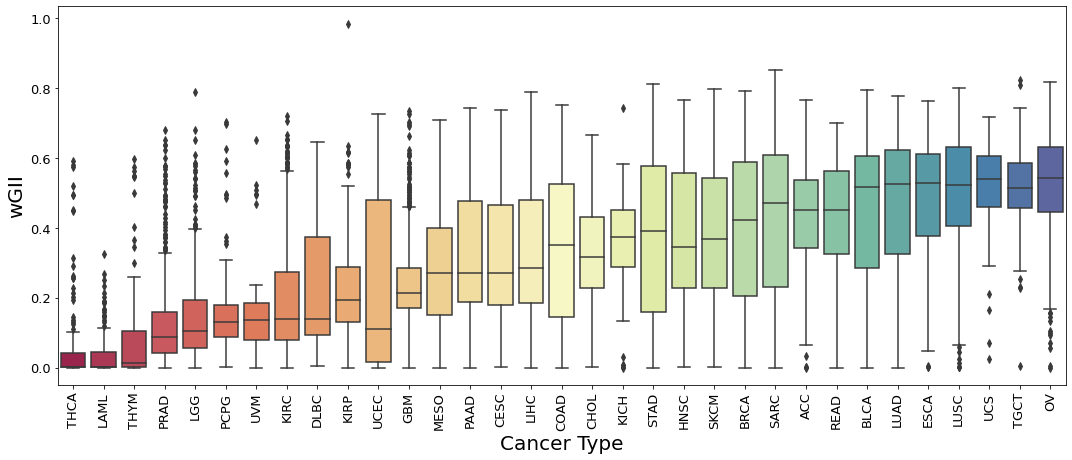

In [30]:
sns.set_palette(palette="Spectral", n_colors=33)

fig = plt.figure(figsize=(15,6.5))
ax = sns.boxplot(x = 'cancer_type', y = 'wGII', data=wgii_df, order=sorted_wGII)
ax.tick_params(axis='x', labelsize=13, labelrotation=90)
ax.tick_params(axis='y', labelsize=13)
ax.set_xlabel('Cancer Type', fontsize=20)
ax.set_ylabel('wGII', fontsize=20)
# plt.title("wGII across cancer types", fontsize=20)
fig.tight_layout()
plt.savefig("../figures/figure1a.pdf")

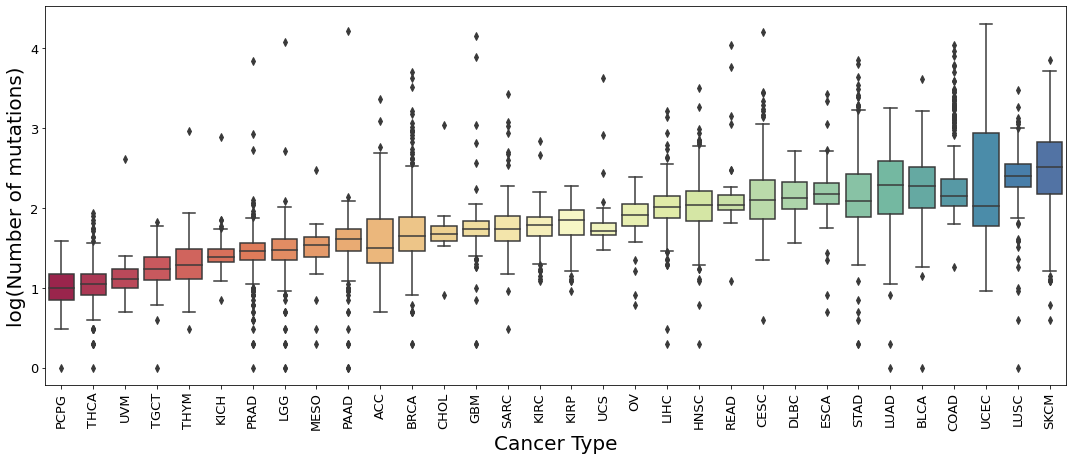

In [31]:
fig = plt.figure(figsize=(15,6.5))
ax = sns.boxplot(x = 'cancer_type', y = 'num_mutations', data=mutation_df, order=sorted_mut)
ax.tick_params(axis='x', labelsize=13, labelrotation=90)
ax.tick_params(axis='y', labelsize=13)
ax.set_xlabel('Cancer Type', fontsize=20)
ax.set_ylabel('log(Number of mutations)', fontsize=20)
# ax.set_ylim(0.25, 1.7)
# plt.title("Number of mutations across cancer types", fontsize=20)
fig.tight_layout()
plt.savefig("../figures/figure1b.pdf")

## Figure 4

In [33]:
weight_per_cancer = weights_df.reset_index(drop=True)

In [34]:
weight_per_cancer

,Sample,Chr,1,2,3,4,5
0,TCGA-02-0001,1,0.602017,0.023816,0.017838,0.344375,0.011954
1,TCGA-76-6280,1,0.036730,0.023488,0.273862,0.014269,0.651651
2,TCGA-J8-A3YD,1,0.932778,0.023399,0.017610,0.014274,0.011938
3,TCGA-J8-A3O1,1,0.035499,0.024063,0.432250,0.014252,0.493936
4,TCGA-76-6282,1,0.036087,0.023506,0.017724,0.014267,0.908416
...,...,...,...,...,...,...,...
168405,TCGA-G2-A2EJ,22,0.036800,0.024316,0.017788,0.909138,0.011958
168406,TCGA-AA-3521-a,22,0.036345,0.171695,0.765769,0.014241,0.011950
168407,TCGA-G2-A2EF,22,0.037784,0.317941,0.618054,0.014270,0.011951
168408,TCGA-AA-3519-a,22,0.038639,0.595291,0.339847,0.014276,0.011947


In [35]:
per_cancer = pd.merge(left = weight_per_cancer, right = ascat[['cancer_type']], left_on='Sample', right_on=ascat['ID']).drop_duplicates(subset='Sample').reset_index(drop=True).drop(['Sample', 'Chr'], axis = 1)
per_cancer = per_cancer.groupby('cancer_type').mean().transpose()
per_cancer

cancer_type,ACC,BLCA,BRCA,CESC,CHOL,COAD,DLBC,ESCA,GBM,HNSC,...,READ,SARC,SKCM,STAD,TGCT,THCA,THYM,UCEC,UCS,UVM
1,0.106638,0.138291,0.169574,0.094665,0.103738,0.137814,0.048618,0.082920,0.130464,0.167395,...,0.094476,0.106697,0.125389,0.129826,0.088611,0.505413,0.230665,0.218628,0.074667,0.304193
2,0.085686,0.154370,0.155356,0.178701,0.054224,0.089024,0.071869,0.129531,0.104640,0.141435,...,0.117736,0.101938,0.157559,0.090604,0.173027,0.034642,0.065724,0.092496,0.218533,0.048651
3,0.349561,0.391422,0.338300,0.357837,0.360519,0.280346,0.395448,0.379311,0.243812,0.199430,...,0.363301,0.422608,0.295398,0.381518,0.324485,0.069895,0.092267,0.321152,0.514292,0.060405
4,0.089151,0.048452,0.047618,0.047584,0.063965,0.073608,0.071707,0.051825,0.076485,0.073055,...,0.052427,0.074355,0.056499,0.064890,0.042399,0.145348,0.146617,0.073418,0.014246,0.166040
5,0.368964,0.267465,0.289152,0.321212,0.417554,0.419208,0.412359,0.356413,0.444599,0.418685,...,0.372060,0.294402,0.365156,0.333161,0.371477,0.244702,0.464726,0.294307,0.178263,0.420711


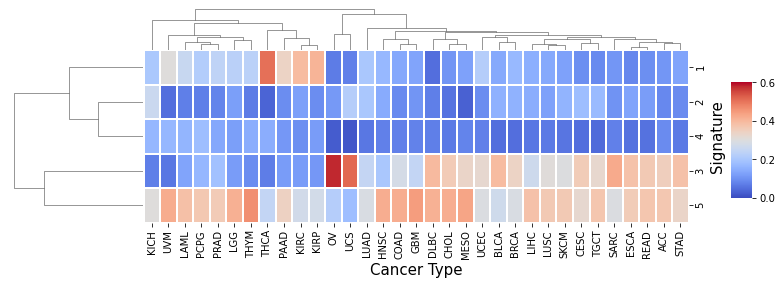

In [37]:
g = sns.clustermap(
    per_cancer, cmap='coolwarm', 
    cbar_pos=(1.02, .3, .03, .4),
    figsize=(10,4), linewidths=0.004,
    dendrogram_ratio=0.2, 
    vmin=0, vmax=0.6,
    # standard_scale=0
    )
g.ax_heatmap.set_xlabel('Cancer Type', fontsize=15)
g.ax_heatmap.set_ylabel('Signature', fontsize=15)
# g.ax_heatmap.set_title("Clustering of mean signature weights", fontsize=18)
g.savefig('../figures/cancertype_clustermap.pdf')

## Figure 5

In [15]:
geneexp_corr = pd.read_table('/home/janneae/cns/steps/allgenes.correlation', sep=' ')
geneexp_corr = geneexp_corr.set_index('Unnamed: 0')
geneexp_corr.index = geneexp_corr.index.rename('Signature')
geneexp_corr = geneexp_corr.fillna(0)
geneexp_corr

,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,...,PRAMEF26,OR8K3,CCDC163,PAGR1,RPS4Y2,TMEM265,TEX13D,ADORA3,DUXB,TEX13C
Signature,,,,,,,,,,,,,,,,,,,,,
Signature_1,0.031690,0.006727,-0.001678,0.108404,0.094647,0.051698,0.093397,0.003195,0.031311,0.041501,...,0.002620,0.009064,0.027999,0.010123,-0.045090,0.012599,0.012735,0.040304,-0.004380,0.017953
Signature_2,0.048481,-0.054436,0.223926,0.056692,0.300090,-0.119787,-0.035386,0.083367,0.005125,0.082676,...,0.072672,0.053860,0.037630,0.056509,-0.052610,0.009725,0.041672,-0.085930,0.045367,0.066716
Signature_3,-0.015981,0.058037,-0.167948,-0.039660,-0.275222,0.119474,0.056740,0.001072,-0.031007,-0.060935,...,-0.047537,-0.052429,-0.048215,-0.052465,0.019826,0.017656,-0.041919,0.087289,-0.028778,-0.046776
Signature_4,-0.059963,0.008263,-0.102545,-0.110890,-0.175082,-0.003511,-0.077813,-0.086797,-0.009094,-0.067379,...,-0.039224,-0.027293,-0.021640,-0.025848,0.082329,-0.030069,-0.020163,-0.008123,-0.019228,-0.054605
Signature_5,-0.039761,0.002783,-0.049896,-0.079317,-0.116548,-0.016806,-0.048461,-0.033024,-0.004656,-0.058595,...,-0.025807,0.002103,-0.033676,-0.020597,0.002122,-0.023118,-0.020323,-0.005611,-0.018339,0.006367


In [16]:
geneexp_pval = pd.read_table('/home/janneae/cns/steps/allgenes.p_vals', sep=' ')
geneexp_pval = geneexp_pval.set_index('Unnamed: 0')
geneexp_pval.index = geneexp_pval.index.rename('Signature')
geneexp_pval = geneexp_pval.fillna(1)
# geneexp_pval = -np.log10(geneexp_pval)
geneexp_pval

,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,...,PRAMEF26,OR8K3,CCDC163,PAGR1,RPS4Y2,TMEM265,TEX13D,ADORA3,DUXB,TEX13C
Signature,,,,,,,,,,,,,,,,,,,,,
Signature_1,0.012675,0.596778,8.950103e-01,1.227968e-17,8.658222e-14,4.735833e-05,1.825219e-13,8.016004e-01,0.013779,1.094065e-03,...,8.367640e-01,0.475951,0.027640,0.425972,3.885032e-04,0.321779,0.316571,1.520074e-03,0.730534,1.579705e-01
Signature_2,0.000136,0.000018,3.656948e-71,8.123128e-06,6.076380e-129,3.252016e-21,5.374413e-03,5.115735e-11,0.686936,7.372090e-11,...,1.049236e-08,0.000022,0.003073,0.000009,3.470473e-05,0.444396,0.001043,1.286341e-11,0.000358,1.500337e-07
Signature_3,0.208807,0.000005,2.243783e-40,1.807712e-03,5.939330e-108,4.124504e-21,7.981075e-06,9.328298e-01,0.014726,1.614572e-06,...,1.836728e-04,0.000037,0.000148,0.000036,1.189237e-01,0.164947,0.000974,6.083078e-12,0.023596,2.327029e-04
Signature_4,0.000002,0.515798,6.185101e-16,2.180797e-18,8.848768e-44,7.824547e-01,8.864398e-10,7.986753e-12,0.474493,1.127786e-07,...,2.029792e-03,0.031812,0.088751,0.042044,8.842618e-11,0.018021,0.112780,5.229333e-01,0.130458,1.727722e-05
Signature_5,0.001759,0.826763,8.625055e-05,4.170872e-10,3.684303e-20,1.862607e-01,1.371215e-04,9.383799e-03,0.714224,3.988410e-06,...,4.236906e-02,0.868621,0.008071,0.105247,8.674419e-01,0.069017,0.109953,6.590476e-01,0.149203,6.165859e-01


In [17]:
fdr_pval = pd.DataFrame(stats.fdr_correction(geneexp_pval)[1])
fdr_pval.columns = geneexp_pval.columns
fdr_pval.index = geneexp_pval.index
fdr_pval_log = -np.log10(fdr_pval)
fdr_pval

,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,...,PRAMEF26,OR8K3,CCDC163,PAGR1,RPS4Y2,TMEM265,TEX13D,ADORA3,DUXB,TEX13C
Signature,,,,,,,,,,,,,,,,,,,,,
Signature_1,0.024162,0.672926,9.223178e-01,1.388286e-16,7.165896e-13,1.430125e-04,1.466483e-12,8.476398e-01,0.026051,2.611125e-03,...,8.758673e-01,0.561155,0.048536,0.512735,1.005274e-03,0.407160,0.401695,3.528716e-03,0.789069,2.232876e-01
Signature_2,0.000381,0.000059,5.496494e-69,2.762917e-05,3.465990e-126,4.823141e-20,1.114029e-02,3.269336e-10,0.751815,4.633921e-10,...,5.212689e-08,0.000072,0.006704,0.000029,1.071369e-04,0.530758,0.002500,8.730405e-11,0.000931,6.458095e-07
Signature_3,0.283230,0.000017,1.008604e-38,4.134363e-03,2.089802e-105,6.072040e-20,2.717922e-05,9.508139e-01,0.027639,6.056459e-06,...,5.024604e-04,0.000114,0.000413,0.000112,1.749461e-01,0.231644,0.002344,4.248209e-11,0.042146,6.254653e-04
Signature_4,0.000009,0.598611,6.121443e-15,2.617269e-17,4.654219e-42,8.319254e-01,4.960768e-09,5.524732e-11,0.559825,4.926288e-07,...,4.594788e-03,0.054977,0.135692,0.070490,5.508865e-10,0.033138,0.167101,6.051130e-01,0.189618,5.598241e-05
Signature_5,0.004034,0.867825,2.495847e-04,2.424253e-09,5.075727e-19,2.570827e-01,3.837193e-04,1.842197e-02,0.775140,1.417859e-05,...,7.094981e-02,0.901659,0.016083,0.157362,9.007205e-01,0.109055,0.163464,7.277099e-01,0.212656,6.905891e-01


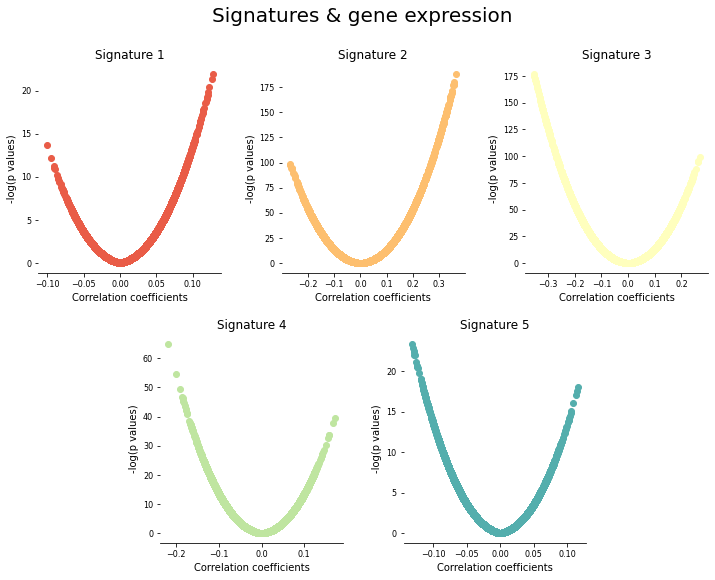

In [18]:
palette = sns.color_palette(palette="Spectral", n_colors=5)

fig = plt.figure(figsize=(12, 8))
ypos = [0, 0, 0, 1, 1]
xpos = [0, 2, 4, 1, 3]

for i in range(5):
    ax = plt.subplot2grid((2,6), (ypos[i], xpos[i]), colspan=2)
    ax.scatter(geneexp_corr.iloc[i], fdr_pval_log.iloc[i], color=palette[i])
    ax.tick_params(axis="both", which="major", labelsize=8)
    ax.set_title(f"Signature {i + 1}", fontsize=12)
    ax.set_ylabel("-log(p values)")
    ax.set_xlabel("Correlation coefficients")
    for i in "top right left".split():
        ax.spines[i].set_visible(False)
    
fig.subplots_adjust(top=0.88, bottom=0.05, wspace=1, hspace=0.3)
fig.suptitle("Signatures & gene expression", fontsize=20)
plt.savefig('../figures/signatures_geneexp.pdf')

In [19]:
gene_expT = gene_exp.transpose()
gene_expT['Sample'] = gene_expT.index

exp = weights_df.reset_index(drop=True).drop(['Chr'], axis = 1).drop_duplicates(subset = ["Sample"])
exp.columns = ['Sample', 'Sig1', 'Sig2', 'Sig3', 'Sig4', 'Sig5']
exp = pd.merge(left = exp, right = gene_expT, on = 'Sample')
exp.index = exp['Sample']
exp = exp.drop(['Sample'], axis = 1)
exp_final = exp.drop(['Sig1', 'Sig2', 'Sig3', 'Sig4', 'Sig5'], axis = 1)
exp_final

,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,...,PRAMEF26,OR8K3,CCDC163,PAGR1,RPS4Y2,TMEM265,TEX13D,ADORA3,DUXB,TEX13C
Sample,,,,,,,,,,,,,,,,,,,,,
TCGA-J8-A3YD,5.1240,-4.2934,5.5659,2.6556,1.1706,1.8564,5.0875,5.1732,3.8719,3.7432,...,-9.9658,-9.9658,1.7575,5.1792,-9.9658,5.2499,-9.9658,0.1519,-9.9658,-6.5064
TCGA-J8-A3O1,5.0423,-2.8262,5.5267,3.1145,1.7446,1.1050,5.0387,5.2483,4.0850,4.2958,...,-9.9658,-9.9658,2.4008,4.5675,-9.9658,5.0286,-9.9658,1.2815,-9.9658,-9.9658
TCGA-J8-A3O0,5.6857,-2.1779,5.6436,2.4439,0.5859,2.7508,4.1954,5.8385,5.8352,3.9147,...,-9.9658,-9.9658,-0.6873,4.9846,-9.9658,5.0743,-9.9658,1.1447,-9.9658,-9.9658
TCGA-J8-A3NZ,5.5466,-5.0116,5.4390,2.7993,1.7009,2.5536,5.9658,5.3327,4.1812,4.0488,...,-9.9658,-9.9658,0.8164,5.0466,-9.9658,5.8958,-9.9658,1.2576,-9.9658,-9.9658
TCGA-J7-8537,6.3829,-1.4305,5.1268,2.1147,1.8282,2.9875,5.6594,6.3820,5.4919,3.9774,...,-9.9658,-9.9658,-0.3022,4.5079,-9.9658,2.9186,-9.9658,2.8955,-9.9658,-9.9658
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-XF-AAN8,3.9478,2.3981,5.4209,0.8164,-0.2328,4.7426,6.6731,5.1035,2.3898,1.9931,...,-9.9658,-9.9658,-0.5125,3.9137,-9.9658,0.4967,-9.9658,3.0961,-9.9658,-9.9658
TCGA-YA-A8S7,5.4660,-9.9658,5.1708,1.5064,1.7828,2.8381,7.6968,6.5758,4.3292,3.1781,...,-9.9658,-9.9658,0.0990,4.4250,-9.9658,1.6649,-9.9658,5.2717,-9.9658,-9.9658
TCGA-ZF-AA4W,3.5875,-9.9658,5.2036,1.0915,1.4962,1.1706,5.0229,5.5404,3.4020,2.6805,...,-9.9658,-9.9658,-0.1345,4.8876,-9.9658,3.5596,-9.9658,-3.3076,-9.9658,-9.9658


In [20]:
pathways = exp_final.transpose()
pathways.reset_index(inplace=True)
pathways = pathways.rename(columns = {'index':'Gene'})
pathways = pd.merge(left = pathways, right = sanchez_vega, on = 'Gene').drop(['Pathway', 'Role'], axis=1)
pathways = pathways.groupby(['Pathway_pretty'], as_index=False, sort=False).mean().set_index('Pathway_pretty').transpose()
pathways

Pathway_pretty,Notch pathway,Myc pathway,Hippo pathway,Nrf2 pathway,RTK/KRAS pathway,Wnt pathway,PI3K pathway,Cell cycle pathway,TGBF pathway,p53 pathway
TCGA-J8-A3YD,2.601717,3.228377,2.613161,6.122933,2.791500,1.820465,4.473633,3.985953,4.201814,3.442243
TCGA-J8-A3O1,2.555559,3.188415,2.493150,6.174367,2.911626,1.617638,4.793539,3.814160,4.567457,3.983857
TCGA-J8-A3O0,2.846448,3.434462,2.616786,6.419267,2.914729,2.046804,4.558339,4.208673,4.527257,3.911471
TCGA-J8-A3NZ,2.676707,3.005423,2.833632,6.198800,2.871971,1.788631,4.741450,4.248067,4.639557,3.532257
TCGA-J7-8537,2.124686,3.103885,2.173821,5.749267,2.809376,1.539512,4.347422,3.955927,4.183414,3.938243
...,...,...,...,...,...,...,...,...,...,...
TCGA-XF-AAN8,2.090510,2.718808,1.867854,5.835000,2.261753,2.554204,3.695133,3.242507,3.951457,3.126900
TCGA-YA-A8S7,1.798031,2.856046,1.564621,5.781633,1.852553,0.505088,3.859100,4.146453,3.423300,3.917743
TCGA-ZF-AA4W,2.046976,3.333708,1.943454,5.920700,1.989668,1.162362,3.594267,4.353880,2.978429,3.486000
TCGA-X7-A8DF,2.477938,3.546038,1.199800,5.707233,1.419416,1.686558,3.908017,4.083827,2.574543,4.170114


In [21]:
pathway_corr = pd.DataFrame(columns=exp_final.columns, index=['Signature_1', 'Signature_2', 'Signature_3', 'Signature_4', 'Signature_5'])

for signature in range(1, 6):
    for pathway in pathway_corr.columns:
        pathway_corr[pathway][f'Signature_{signature}'] = st.pearsonr(exp[f'Sig{signature}'], exp_final[pathway])[0]
pathway_corr

/home/janneae/miniconda3/envs/pc/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,...,PRAMEF26,OR8K3,CCDC163,PAGR1,RPS4Y2,TMEM265,TEX13D,ADORA3,DUXB,TEX13C
Signature_1,-0.010288,0.059646,-0.16452,-0.033093,-0.271527,0.11769,0.057677,-0.001702,-0.027976,-0.064956,...,-0.045454,-0.052541,-0.041105,-0.048726,0.010769,0.021663,-0.034927,0.094113,-0.028862,-0.040642
Signature_2,0.048214,-0.053619,0.214184,0.043301,0.271032,-0.115217,-0.041857,0.090171,-0.005122,0.080773,...,0.069374,0.048991,0.04349,0.052921,-0.036615,0.016482,0.035601,-0.080868,0.034038,0.053891
Signature_3,-0.03775,0.016223,-0.123629,-0.020469,-0.137496,0.040175,0.011841,-0.053033,-0.015874,-0.042144,...,-0.013971,-0.01181,-0.009352,-0.014024,0.03715,-0.016467,-0.021818,0.028821,-0.018589,-0.036583
Signature_4,-0.010091,-0.006702,-0.002843,0.026539,0.069233,0.025643,0.026308,-0.03742,0.031306,0.014575,...,-0.017639,0.003519,0.003966,-0.002352,0.008699,-0.010438,0.014271,-0.004934,0.000136,0.002099
Signature_5,-0.033701,0.0119,-0.051059,-0.093214,-0.145821,-0.069259,-0.103868,-0.079696,0.018593,-0.062768,...,-0.028127,-0.012837,-0.028634,-0.013886,0.002799,-0.046526,-0.029649,-0.012978,-0.004898,-0.014171


In [22]:
pathway_pval = pd.DataFrame(columns=exp_final.columns, index=['Signature_1', 'Signature_2', 'Signature_3', 'Signature_4', 'Signature_5'])

for signature in range(1, 6):
    for pathway in pathway_pval.columns:
        pathway_pval[pathway][f'Signature_{signature}'] = st.pearsonr(exp[f'Sig{signature}'], exp_final[pathway])[1]
pathway_pval

/home/janneae/miniconda3/envs/pc/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,...,PRAMEF26,OR8K3,CCDC163,PAGR1,RPS4Y2,TMEM265,TEX13D,ADORA3,DUXB,TEX13C
Signature_1,0.418448,0.000003,0.0,0.009235,0.0,0.0,0.000006,0.893525,0.027771,0.0,...,0.000348,0.000036,0.001221,0.000126,0.397064,0.088413,0.006005,0.0,0.023195,0.001386
Signature_2,0.000148,0.000024,0.0,0.000657,0.0,0.0,0.000991,0.0,0.687111,0.0,...,0.0,0.000116,0.000622,0.000031,0.003972,0.19488,0.005101,0.0,0.007415,0.000022
Signature_3,0.00298,0.201993,0.0,0.107421,0.0,0.001574,0.351745,0.00003,0.211874,0.000914,...,0.271889,0.353014,0.462045,0.270068,0.003472,0.195302,0.086167,0.023389,0.143734,0.004003
Signature_4,0.42742,0.598166,0.823072,0.036848,0.0,0.043703,0.038525,0.003242,0.013794,0.2517,...,0.165363,0.781963,0.755147,0.853269,0.493908,0.411716,0.261705,0.698008,0.991466,0.868914
Signature_5,0.008025,0.349323,0.000059,0.0,0.0,0.0,0.0,0.0,0.143667,0.000001,...,0.026941,0.312696,0.024306,0.274791,0.825787,0.000251,0.019691,0.307434,0.70011,0.265078


In [33]:
pathwayfdr_pval = pd.DataFrame(stats.fdr_correction(pathway_pval)[1])
pathwayfdr_pval.columns = pathway_pval.columns
pathwayfdr_pval.index = pathway_pval.index
# pathway_pval_log = -np.log10(pathwayfdr_pval)
# pathwayfdr_pval
-np.log10(pathwayfdr_pval + 1)

/home/janneae/miniconda3/envs/pc/lib/python3.10/site-packages/mne/stats/multi_comp.py:62: RuntimeWarning: invalid value encountered in less
  reject = pvals_sorted < (ecdffactor * alpha)
/home/janneae/miniconda3/envs/pc/lib/python3.10/site-packages/mne/stats/multi_comp.py:71: RuntimeWarning: invalid value encountered in greater
  pvals_corrected[pvals_corrected > 1.0] = 1.0


TypeError: loop of ufunc does not support argument 0 of type numpy.float64 which has no callable log10 method

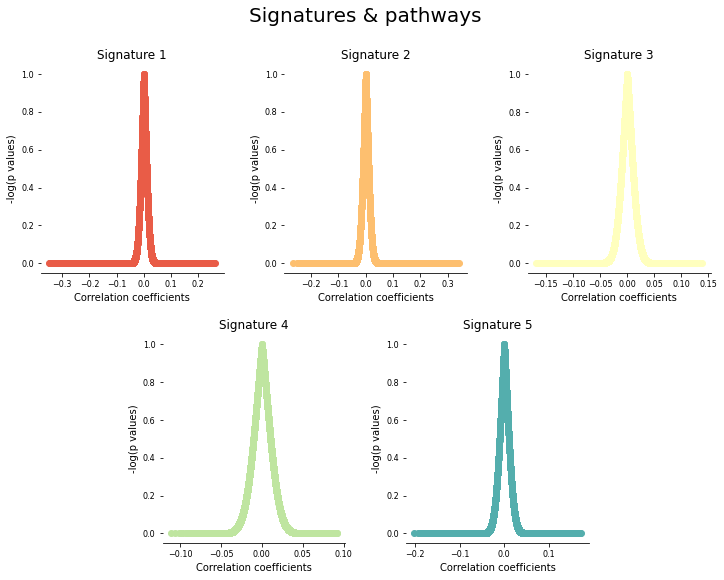

In [25]:
palette = sns.color_palette(palette="Spectral", n_colors=5)

fig = plt.figure(figsize=(12, 8))
ypos = [0, 0, 0, 1, 1]
xpos = [0, 2, 4, 1, 3]

for i in range(5):
    ax = plt.subplot2grid((2,6), (ypos[i], xpos[i]), colspan=2)
    ax.scatter(pathway_corr.iloc[i], pathwayfdr_pval.iloc[i], color=palette[i])
    ax.tick_params(axis="both", which="major", labelsize=8)
    ax.set_title(f"Signature {i + 1}", fontsize=12)
    ax.set_ylabel("-log(p values)")
    ax.set_xlabel("Correlation coefficients")
    for i in "top right left".split():
        ax.spines[i].set_visible(False)
    
fig.subplots_adjust(top=0.88, bottom=0.05, wspace=1, hspace=0.3)
fig.suptitle("Signatures & pathways", fontsize=20)
plt.savefig('../figures/signatures_pathways.pdf')

## Figur 6

In [49]:
import reactome2py

## Figur 7

In [94]:
from statannot import add_stat_annotation

In [95]:
top10 = mutations[mutations.PolyPhen_num > 0.99].groupby('Hugo_Symbol').count().sort_values('Entrez_Gene_Id', ascending=False)
top10 = list(top10.index[0:10])

In [96]:
top10 = ['ARID1A', 'TP53', 'VHL', 'KRAS', 'NRAS', 'BRCA1', 'BRCA2', 'EGFR', 'CDKN2A', 'CDKN1A', 'NFE2L2', 'PTEN', 'PIK3CA', 'BRAF', 'MAP3K1','SMAD4', 'MAP2K4', 'NOTCH1', 'KEAP1']

In [97]:
mut = weights_df.reset_index(drop=True).drop('Chr', axis=1)

mut = mut.groupby('Sample').mean()
mut = pd.merge(left = mut, right = maf[['mutatated_genes']], left_on = 'Sample', right_on=maf['sampleID'])
mut = pd.merge(left = mut, right = ascat[['cancer_type']], left_on = 'Sample', right_on = ascat['ID']).drop_duplicates(subset='Sample').reset_index(drop=True)

for gene in top10:
    mut[gene] = np.where(mut['mutatated_genes'].str.contains(gene), True, False)
mut

,Sample,1,2,3,4,5,mutatated_genes,cancer_type,ARID1A,TP53,...,CDKN1A,NFE2L2,PTEN,PIK3CA,BRAF,MAP3K1,SMAD4,MAP2K4,NOTCH1,KEAP1
0,TCGA-02-0033,0.345819,0.088625,0.017723,0.389311,0.158522,"TP53, PIK3CA",GBM,False,True,...,False,False,False,True,False,False,False,False,False,False
1,TCGA-02-2466,0.036537,0.138033,0.360225,0.050238,0.414967,"PTPN6, SMARCA4, LRP1B, EGFR",GBM,False,False,...,False,False,False,False,False,False,False,False,False,False
2,TCGA-02-2485,0.165941,0.575558,0.059797,0.142976,0.055727,"TP53, TP53, EGFR",GBM,False,True,...,False,False,False,False,False,False,False,False,False,False
3,TCGA-02-2486,0.154654,0.142859,0.135723,0.252107,0.314657,ATR,GBM,False,False,...,False,False,False,False,False,False,False,False,False,False
4,TCGA-04-1331,0.043968,0.328617,0.292741,0.039418,0.295256,"PTPRC, NF1",OV,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4535,TCGA-ZQ-A9CR,0.072029,0.064746,0.352070,0.135477,0.375677,LRP1B,STAD,False,False,...,False,False,False,False,False,False,False,False,False,False
4536,TCGA-ZR-A9CJ,0.078829,0.118113,0.386239,0.184793,0.232026,"PRF1, CDH11, TP53, NFE2L2, EP300",ESCA,False,True,...,False,True,False,False,False,False,False,False,False,False
4537,TCGA-ZS-A9CE,0.130711,0.524454,0.055524,0.062162,0.227148,PIK3CA,LIHC,False,False,...,False,False,False,True,False,False,False,False,False,False
4538,TCGA-ZS-A9CG,0.511409,0.344400,0.026367,0.087141,0.030683,"CTNNB1, CASP3",LIHC,False,False,...,False,False,False,False,False,False,False,False,False,False


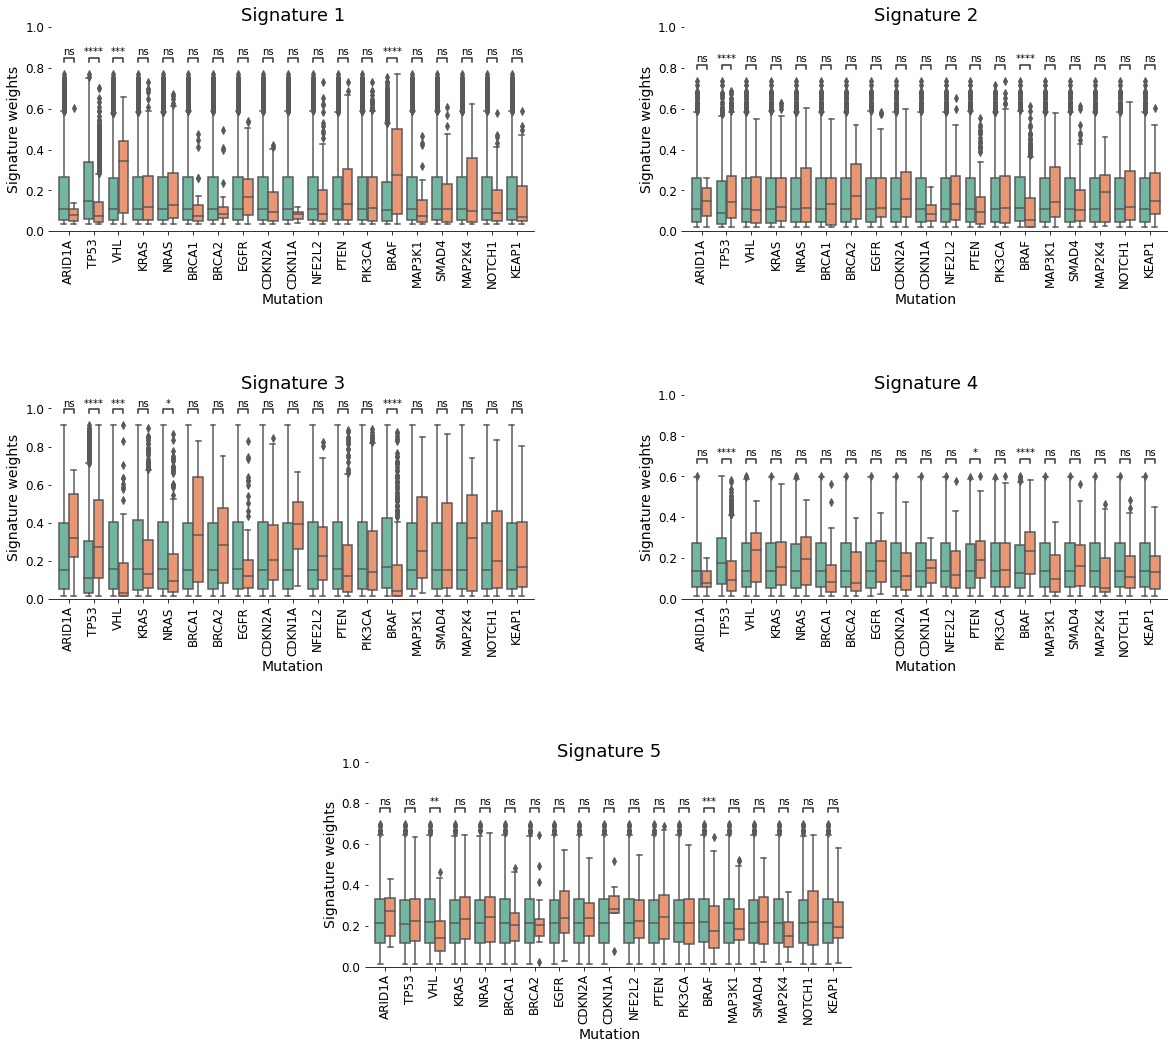

In [105]:
palette = sns.color_palette(palette="Spectral", n_colors=10)

fig = plt.figure(figsize=(20,15))
ypos = [0, 0, 1, 1, 2]
xpos = [0, 2, 0, 2, 1]

for i in range(5):
    
    df = pd.DataFrame(data=mut, columns=['1', '2', '3', '4', '5'] + top10)
    df = pd.melt(df, id_vars=['1', '2', '3', '4', '5'], var_name='Mutation', value_name='Mutated')
    df = pd.melt(df, id_vars=['Mutation', 'Mutated'], var_name='Signature', value_name='Weight')
    df = df[df['Signature'] == str(i + 1)]
    
    ax = plt.subplot2grid((3,4), (ypos[i], xpos[i]), colspan=2)
    ax = sns.boxplot(x = 'Mutation', y = 'Weight', data=df, hue='Mutated', palette='Set2')
    ax.tick_params(axis="both", which="major", labelsize=8)
    ax.set_title(f"Signature {i + 1}", fontsize=18)
    ax.set_ylabel("Signature weights", fontsize=14)
    ax.set_xlabel("Mutation", fontsize=14)
    ax.set_ylim(0, 1)
    ax.tick_params(axis='x', labelsize=12, labelrotation=90)
    ax.tick_params(axis='y', labelsize=12)
    ax.get_legend().remove()
    for i in "top right left".split():
        ax.spines[i].set_visible(False)
    
    add_stat_annotation(ax, x = 'Mutation', y = 'Weight', data=df, hue='Mutated',
                    box_pairs=[(("ARID1A", True), ("ARID1A", False)), 
                               (("TP53", True), ("TP53", False)),
                               (("VHL", True), ("VHL", False)),
                               (("KRAS", True), ("KRAS", False)),
                               (("NRAS", True), ("NRAS", False)),
                               (("BRCA1", True), ("BRCA1", False)),
                               (("BRCA2", True), ("BRCA2", False)),
                               (("EGFR", True), ("EGFR", False)),
                               (("CDKN2A", True), ("CDKN2A", False)),
                               (("CDKN1A", True), ("CDKN1A", False)),
                               (("NFE2L2", True), ("NFE2L2", False)),
                               (("PTEN", True), ("PTEN", False)),
                               (("PIK3CA", True), ("PIK3CA", False)),
                               (("BRAF", True), ("BRAF", False)),
                               (("MAP3K1", True), ("MAP3K1", False)),
                               (("SMAD4", True), ("SMAD4", False)),
                               (("MAP2K4", True), ("MAP2K4", False)),
                               (("NOTCH1", True), ("NOTCH1", False)),
                               (("KEAP1", True), ("KEAP1", False))
                                ],
                            test='Mann-Whitney', text_format='star', loc='inside', verbose=0)

fig.subplots_adjust(top=0.92, bottom=0.05, wspace=0.9, hspace=0.8)
# fig.suptitle("Signatures and most oncogenic mutations", fontsize=22)
# fig.tight_layout()
plt.savefig("../figures/figure7.pdf")

# False to the left and true to the right

## Figur 8

In [7]:
from lifelines import CoxPHFitter

In [8]:
survivaldata = pd.read_table('/home/janneae/TCGA/DerivedData/TCGA_survival_data_clean.txt')
survivaldata.head()

,Unnamed: 0,bcr_patient_barcode,type,age_at_initial_pathologic_diagnosis,gender,race,ajcc_pathologic_tumor_stage,clinical_stage,histological_type,histological_grade,...,residual_tumor,OS,OS.time,DSS,DSS.time,DFI,DFI.time,PFI,PFI.time,Redaction
0,1,TCGA-OR-A5J1,ACC,58.0,MALE,WHITE,Stage II,[Not Applicable],Adrenocortical carcinoma- Usual Type,[Not Available],...,NaN,1.0,1355.0,1.0,1355.0,1.0,754.0,1.0,754.0,NaN
1,2,TCGA-OR-A5J2,ACC,44.0,FEMALE,WHITE,Stage IV,[Not Applicable],Adrenocortical carcinoma- Usual Type,[Not Available],...,NaN,1.0,1677.0,1.0,1677.0,NaN,NaN,1.0,289.0,NaN
2,3,TCGA-OR-A5J3,ACC,23.0,FEMALE,WHITE,Stage III,[Not Applicable],Adrenocortical carcinoma- Usual Type,[Not Available],...,NaN,0.0,2091.0,0.0,2091.0,1.0,53.0,1.0,53.0,NaN
3,4,TCGA-OR-A5J4,ACC,23.0,FEMALE,WHITE,Stage IV,[Not Applicable],Adrenocortical carcinoma- Usual Type,[Not Available],...,NaN,1.0,423.0,1.0,423.0,NaN,NaN,1.0,126.0,NaN
4,5,TCGA-OR-A5J5,ACC,30.0,MALE,WHITE,Stage III,[Not Applicable],Adrenocortical carcinoma- Usual Type,[Not Available],...,NaN,1.0,365.0,1.0,365.0,NaN,NaN,1.0,50.0,NaN


In [9]:
data = weights_df.reset_index(drop=True).drop('Chr', axis=1)
data = data.groupby('Sample').mean()
data = pd.merge(left = data, right = survivaldata[['OS', 'OS.time']], left_on = 'Sample', right_on = survivaldata.bcr_patient_barcode)
# data['vital_status'] = pd.factorize(data['vital_status'], sort=True)[0]
data = data.drop('Sample', axis=1).dropna()
data

,1,2,3,4,5,OS,OS.time
0,0.200241,0.164661,0.017799,0.389735,0.227564,1.0,358.0
1,0.077347,0.023942,0.598511,0.014257,0.285942,1.0,345.0
2,0.268455,0.447006,0.135015,0.057688,0.091836,1.0,558.0
3,0.166998,0.105225,0.133706,0.187312,0.406760,1.0,322.0
4,0.036941,0.023843,0.253460,0.228899,0.456857,1.0,1077.0
...,...,...,...,...,...,...,...
7031,0.566754,0.064188,0.017725,0.283947,0.067386,1.0,1386.0
7032,0.130711,0.524454,0.055524,0.062162,0.227148,0.0,1241.0
7033,0.511409,0.344400,0.026367,0.087141,0.030683,0.0,341.0
7034,0.120188,0.023688,0.129023,0.372400,0.354701,0.0,1398.0


In [10]:
data.isnull().sum()

1          0
2          0
3          0
4          0
5          0
OS         0
OS.time    0
dtype: int64

In [11]:
T = data['OS.time']
E = data.OS

<AxesSubplot:xlabel='timeline'>

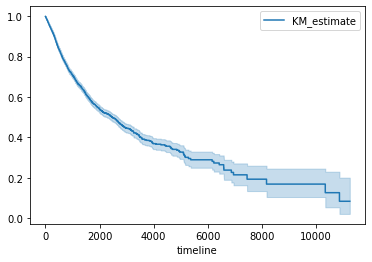

In [12]:
kmf = KaplanMeierFitter()
kmf.fit(durations = T, event_observed = E)
kmf.plot_survival_function()

In [13]:
median_ = kmf.median_survival_time_
median_confidence_interval_ = median_survival_times(kmf.confidence_interval_)
print(median_)
print(median_confidence_interval_)

2464.0
     KM_estimate_lower_0.95  KM_estimate_upper_0.95
0.5                  2279.0                  2680.0


In [14]:
cph = CoxPHFitter(penalizer=0.1)
cph.fit(data, duration_col='OS.time', event_col='OS')
cph.print_summary()

/home/janneae/miniconda3/envs/cns/lib/python3.10/site-packages/lifelines/utils/printer.py:62: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return summary_df[columns].to_latex(float_format="%." + str(self.decimals) + "f")


<lifelines.CoxPHFitter: fitted with 6990 total observations, 4750 right-censored observations>
             duration col = 'OS.time'
                event col = 'OS'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 6990
number of events observed = 2240
   partial log-likelihood = -17969.60
         time fit was run = 2022-05-19 13:26:01 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
1          -0.70       0.49       0.15            -0.99            -0.41                 0.37                 0.66
2           0.27       1.31       0.15            -0.03             0.56                 0.97                 1.75
3           0.19       1.21       0.11            -0.02             0.40                 0.98                 1.49
4          -0.29       0.75       0.18            -0.65             0.07                 0.52                 1.08
5           0.46       1.58       0.16             0.14             0.77                 1.16                 2.15

            cmp to     z      p   -log2(p)
covariate                                 
1             0.00 -4.76 <0.005      18.94
2             0.00  1.79   0.07       3.76
3             0.00  1.74   0.08       3.61
4             0.00 -1.55   0.12       3.06
5             0.00  2.87 <0.005       7.93
---
Concordance = 0.55
Partial AIC = 35949.19
log-likelihood ratio test = 103.91 on 5 df
-log2(p) of ll-ratio test = 66.77

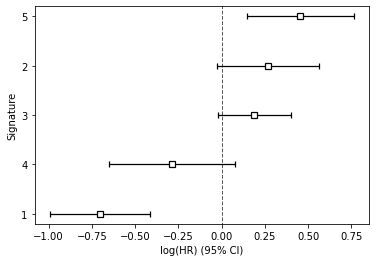

In [21]:
cph.plot()
plt.ylabel("Signature")
plt.savefig("../figures/figurecph.pdf")

In [16]:
cph.check_assumptions(data, p_value_threshold = 0.05)

Proportional hazard assumption looks okay.


/home/janneae/miniconda3/envs/cns/lib/python3.10/site-packages/lifelines/fitters/mixins.py:108: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead.
  for variable in self.params_.index & (columns or self.params_.index):


[]

In [17]:
results = proportional_hazard_test(cph, data, time_transform='rank')
results.print_summary(decimals=3, model="untransformed variables")

/home/janneae/miniconda3/envs/cns/lib/python3.10/site-packages/lifelines/statistics.py:143: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return self.summary.to_latex()


<lifelines.StatisticalResult: proportional_hazard_test>
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 6990 total observations, 4750 right-censored observations>
         test_name = proportional_hazard_test

---
   test_statistic    p  -log2(p)
1            0.01 0.92      0.11
2            0.41 0.52      0.94
3            0.74 0.39      1.36
4            0.47 0.49      1.02
5            0.11 0.74      0.43